BlockSeparation+NonLinearEncoder+UNetdecoder(By Block)

4*4kernel,1:8,

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys

In [25]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data02', 'MNIST_AE[002]_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)

1212
/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data02/MNIST_AE[002]_result


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [27]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)
batch_size = 100 #
train_dataloader = DataLoader(mnist_train,batch_size,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size,shuffle=False)

In [28]:
def split_into_kernels(image, kernel_size):

    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, -1, kernel_size, kernel_size)

    return kernels

In [29]:
#Encoder5DX
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,alpha=0.6):
        super(Encoder, self).__init__()

        self.kernel_size = kernel_size
        self.kernel_in = int(kernel_size**2)
        self.leverage = leverage
        real_part = nn.Parameter(torch.randn(int(self.kernel_in/leverage), self.kernel_in)*(1/np.sqrt(self.kernel_in)))
        imag_part = nn.Parameter(torch.randn(int(self.kernel_in/leverage), self.kernel_in)*(1/np.sqrt(self.kernel_in)))
        self.B = torch.complex(real_part, imag_part).detach()
        self.B.requires_grad = False

        self.alpha = alpha
    

    def forward(self, x):
        b, n_x, k, _ = x.shape
        x = x.view(b*n_x,-1)
        x = torch.exp(1j*self.alpha*x)
        x=x.T#[16,4900]
        x = torch.matmul(self.B, x).T#[4900, 2]
        x = torch.abs(x) ** 2
        x = x.reshape(b,-1,int(self.kernel_in/self.leverage))#[100, 49,2]
        return x

In [30]:
#NewDecoder

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            residual = self.shortcut(residual)#outと同じチャンネル数に合わせる
        out += residual#残差接続
        out = self.relu(out)
        return out
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    

class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch):
        super(UNetDecoder, self).__init__()

        self.ch=ch
        self.fc = nn.Linear(num_in, ch*1*1)
        self.bottleneck = ResidualBlock(ch,ch,3)
        self.up1 = UpBlock(ch,ch)
        self.res1 = ResidualBlock(ch+ch,ch,3)
        self.up2 = UpBlock(ch,ch)
        self.res2 = ResidualBlock(ch+ch,ch,3)
        self.out_conv = nn.Conv2d(ch+ch, 1, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b = x.size(0)
        x = self.fc(x)
        x = x.view(b, self.ch, 1, 1) #[b,16,1,1]
        x0 = self.bottleneck(x)  
        x1 = self.up1(x0) #[b,16,2,2]
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest') 
        x1 = torch.cat([x1, x0_upsampled], dim=1)#[b,32,2,2]
        x1 = self.res1(x1)#[b,16,2,2]
        x2 = self.up2(x1)#[b,16,4,4]
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')
        x2 = torch.cat([x2, x1_up], dim=1)#[b,32,4,4]
        #x_out = self.res2(x2)
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out) 
        x_out = x_out.view(b, -1)  
        return x_out

In [31]:
class AutoEncoder(nn.Module):
    def __init__(self,DofIN,kernel_size,leverage,ch):
        super(AutoEncoder, self).__init__()

        self.kernel_size = kernel_size
        sq_kernel = kernel_size**2
        self.encoder = Encoder(kernel_size,leverage)  
        self.decoder1 = UNetDecoder(int(sq_kernel/leverage),ch)

        self.img_h = 28
        self.img_w = 28
        self.patch_per_row = self.img_w // self.kernel_size
        self.patch_per_col = self.img_h // self.kernel_size

    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28) 
        x = split_into_kernels(x,self.kernel_size)#[100,49,4,4]
        x = self.encoder(x) #[b,49,2]
        b, n_patches, d = x.size()  # d=2
        x = x.view(b*n_patches, d)  #[b*49,2]
        x = self.decoder1(x)#[b,49,16]
        x = x.view(b, n_patches, 16)#[b,49,16]
        x = x.view(b,-1,self.kernel_size,self.kernel_size)#[100,49,4,4]
        x = x.view(b, self.patch_per_col, self.patch_per_row, self.kernel_size, self.kernel_size)#[100,7,7,4,4]
        x = x.permute(0,1,3,2,4).contiguous().view(b,1,self.img_h,self.img_w)
        return x

In [32]:
DofIN = 784 ##
leverage = 8 ##圧縮倍率
kernel_size = 4 #カーネルサイズ
ch = 16

num_N = DofIN/leverage

model = AutoEncoder(DofIN,kernel_size,leverage,ch)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
loss_train_ = []
loss_test_ = []

max_epochs = 10
for epoch in range(max_epochs):
    loss_train = 0
    loss_test = 0
    for (x,t) in train_dataloader:

        sys.stderr.write('\rEpoch: %d/%d' % (epoch, max_epochs)) 
        sys.stderr.flush()
        
        y = model(x)
        loss = criterion(y.view(y.size(0), -1), x.view(x.size(0), -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
       
    loss_train_avg = loss_train / len(train_dataloader)

    with torch.no_grad():
        for x, t in test_dataloader:
            y = model(x)
            loss = criterion(y.view(y.size(0), -1), x.view(x.size(0), -1))
        
            loss_test += loss.item()

    loss_test_avg = loss_test / len(test_dataloader)

    loss_train_.append(loss_train_avg)
    loss_test_.append(loss_test_avg)
    



Epoch: 9/10

In [34]:
All_loss_train_avg = sum(loss_train_)/len(loss_train_)
All_loss_test_avg = sum(loss_test_)/len(loss_test_)

Last_loss_train = loss_train_[-1]
Last_loss_test = loss_test_[-1]

print('Train MSE AVG:  ',All_loss_train_avg)
print('Test MSE AVG:   ',All_loss_test_avg)

print('Train Last MSE: ',Last_loss_train)
print('Test Last MSE:  ',Last_loss_test)

Train MSE AVG:   0.03601357649390896
Test MSE AVG:    0.03588749655336142
Train Last MSE:  0.03467241717502475
Test Last MSE:   0.0356267998740077


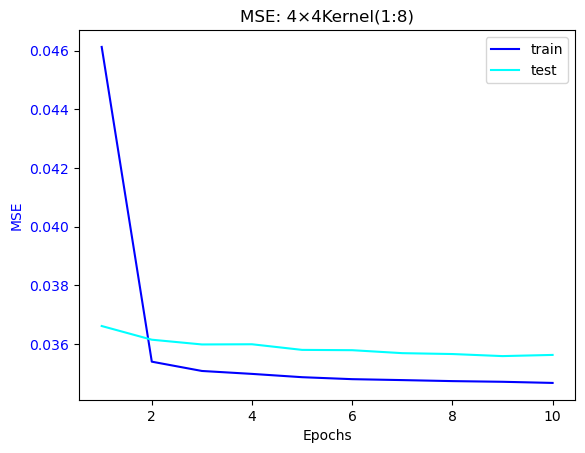

In [35]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d×%dKernel(1:%d)'%(kernel_size,kernel_size,leverage) ##
plt.title(title)
plt.legend()
file_name = '%d_%d%dKernel(1:%d).png'%(int(formatted_date),kernel_size,kernel_size,leverage)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

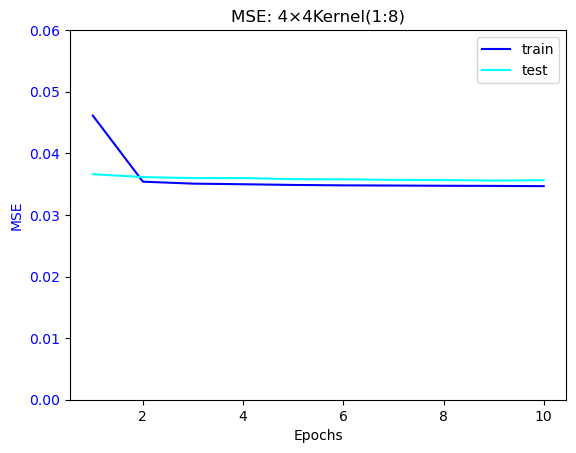

In [36]:
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.ylim(0,0.06)
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d×%dKernel(1:%d)'%(kernel_size,kernel_size,leverage) ##
plt.title(title)
plt.legend()
file_name = '%d_%d%dKernel(1:%d)_ex.png'%(int(formatted_date),kernel_size,kernel_size,leverage)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

In [37]:
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] 
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

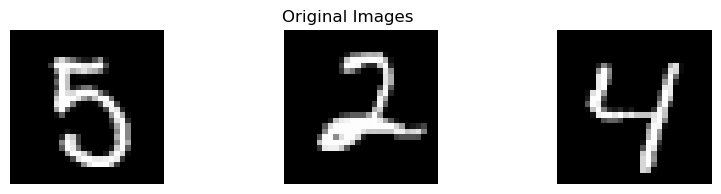

In [38]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:
        break
show_images(test_images, test_labels,"Original Images")

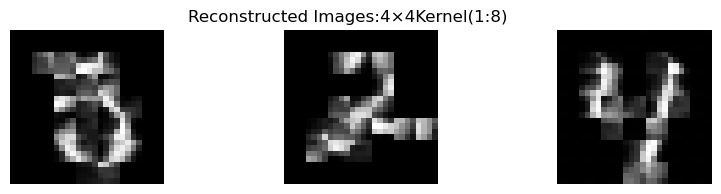

In [39]:
with torch.no_grad():
    reconstructed_images = model(test_images)
    show_images(reconstructed_images,test_labels, "Reconstructed Images:%d×%dKernel(1:%d)"%(kernel_size,kernel_size,leverage))
    file_name = '%d_ReImage%d×%dKernel(1:%d).png'%(int(formatted_date),kernel_size,kernel_size,leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

In [40]:
import csv
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data','texts') 
print(save_directory)
os.makedirs(save_directory, exist_ok=True)
file_name = 'AE[photonic001]_list.csv'##
full_path = os.path.join(save_directory, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(loss_test_)

/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data/texts
